In [1]:
# %matplotlib notebook
from skimage import io, measure, feature, util, color, morphology
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
from scipy.spatial import distance
import numpy as np
import scipy.interpolate as itp
from matplotlib.patches import Ellipse
import trackpy as tp
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')

### Read in the surface elevation $\eta$

In [2]:
class Case(object):
    """ This class defines methods specific to cases.
        Attributes: 
            self.NL 
    """
    def __init__(self, NL=20, LEVEL=8, path='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_20_Htheta0.51/'):
        self.NL = NL 
        self.LEVEL = LEVEL
        self.path = path   
        
case_field1 = Case(NL=15, LEVEL=10, 
                   path='/projects/DEIKE/jiarongw/multilayer/tests/field_new_200m_P0.02_RE40000_10_15_rand4_Htheta0.503_zerodiffnew/')
case = case_field1
case.L = 200; case.H = 40; case.kp = 2*np.pi/case.L*5; case.cp = (9.8/case.kp)**0.5


# Nh = 2**case.LEVEL; Nl = case.NL; L = case.L; H = case.H; cp = case.cp; kp = case.kp
# case.dict = read_full (case, tseries=(0,40))

In [3]:
t = 100
N = 1024; L0=200; dx = L0/N

filename = case.path + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]

filename = case.path + 'surface/ux_matrix_%g' %t
ux = np.fromfile(filename, dtype=np.float32)
ux = ux.reshape(N+1,N+1); ux = ux[1:,1:]

filename = case.path + 'surface/ux_matrix_%g' %t
uy = np.fromfile(filename, dtype=np.float32)
uy = uy.reshape(N+1,N+1); uy = uy[1:,1:]

filename = case.path + 'surface/ux_matrix_%g' %t
uz = np.fromfile(filename, dtype=np.float32)
uz = uz.reshape(N+1,N+1); uz = uz[1:,1:]

case.dict1 = {'t':t, 'eta':eta, 'ux':ux, 'uy':uy, 'uz':uz, 'uh':(ux**2+uy**2)**0.5}

In [23]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def detect_slope(grad, threshold):
    return (np.logical_not(grad > threshold))

# if method == 0:
#     a, b = detect_ridges(eta, sigma=1.0) # Maxima and minima ridges
#     delta = self.config.L0/2**self.LEVEL # Normalize the curvature by grid size
#     b_norm = b/delta**2                
#     b_ = np.logical_not(b_norm > threshold) # Is this value fixed???
#     # Extra filtering by above 2.5 sigma (we can kind of use something between 2.5-3\sigma)
#     if EXTRA_FILTER == True:
#         height_filter = np.logical_not(eta < 2.5*np.var(eta)**0.5)
#         b_ = b_*height_filter
# elif method == 1:
#     b_ = detect_slope(eta_gradx, threshold=threshold)                     

In [16]:
''' This function pad the N*N array into a (N+NP)*(N+NP) array based on periodic boundary condition. '''
def padding(matrix, NP):
    dims = matrix.shape
    matrixp = np.zeros((dims[0]+2*NP, dims[1]+2*NP))
    matrixp[NP:-NP,NP:-NP] = np.copy(matrix)
    matrixp[0:NP,NP:-NP] = np.copy(matrix[-NP:,:])
    matrixp[-NP:,NP:-NP] = np.copy(matrix[0:NP,:])
    matrixp[NP:-NP,0:NP] = np.copy(matrix[:,-NP:])
    matrixp[NP:-NP,-NP:] = np.copy(matrix[:,0:NP])
    return matrixp

In [17]:
eta_pad = padding(eta, NP=2)

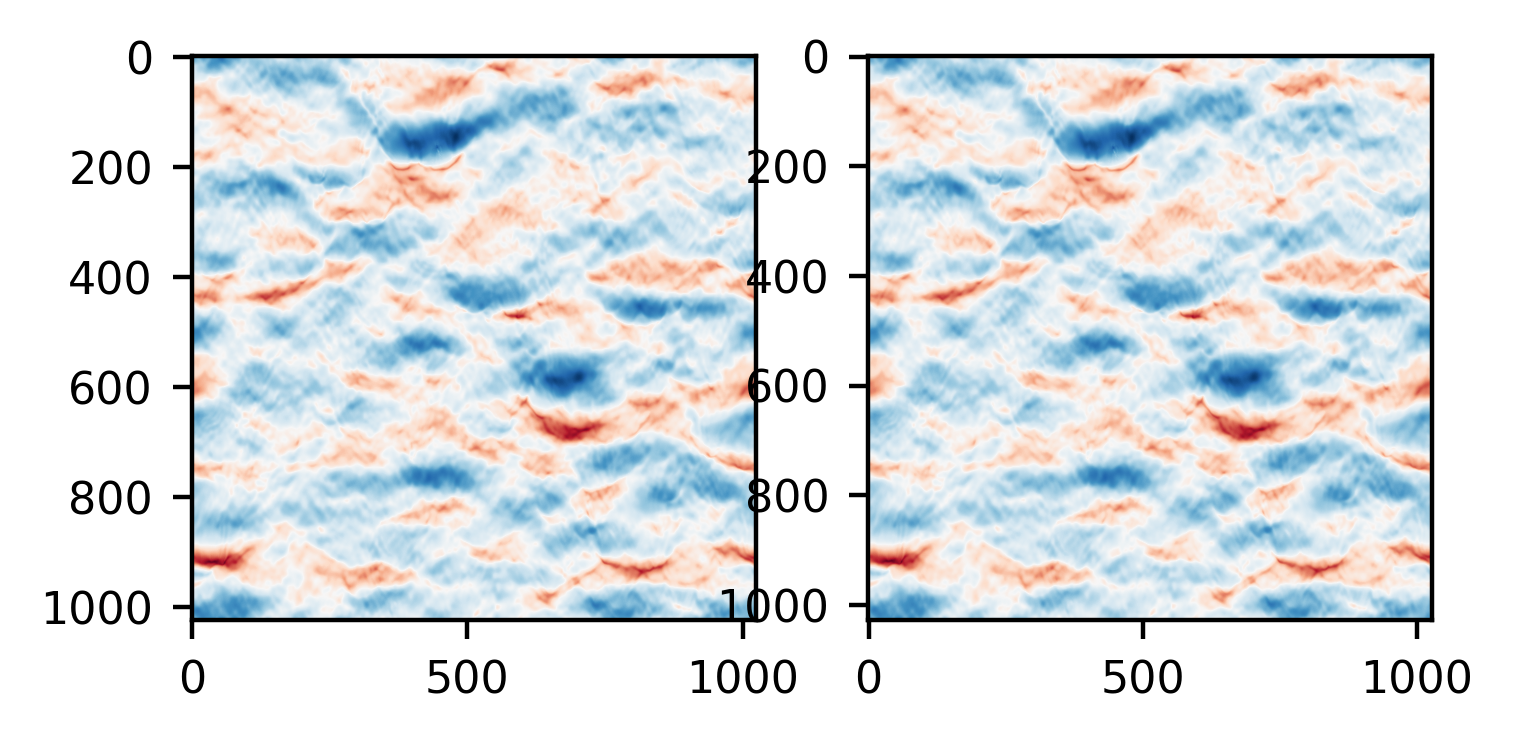

In [19]:
fig, axes = plt.subplots(1,2,figsize=[4,2])
axes[0].imshow(eta, cmap='RdBu_r')
axes[1].imshow(eta_pad, cmap='RdBu_r')

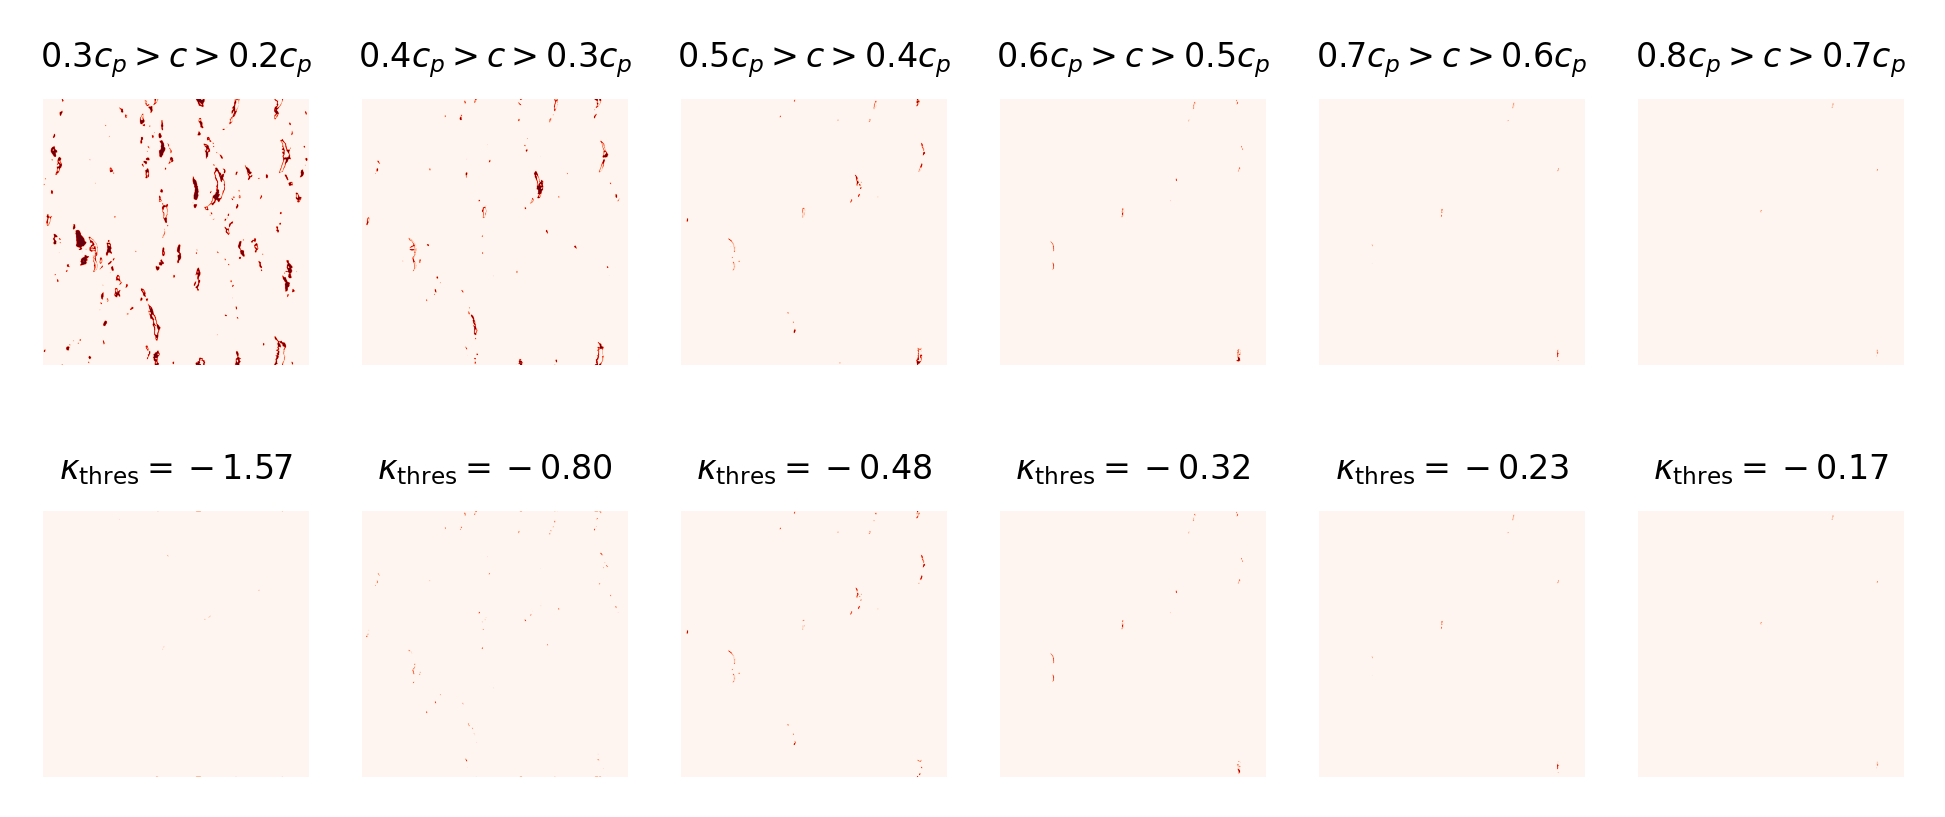

In [24]:
fig,axes = plt.subplots(2,6, figsize=[6,2.5])
cbins = np.arange(0.2,0.8,0.1)

area = np.zeros(case.dict1['eta'].shape)

for i in range(0,6):
    # level set of the horizontal velocity
    levelset = np.array((case.dict1['uh'] > cbins[i]*case.cp)&(case.dict1['uh'] < cbins[i+1]*case.cp), dtype=int)
    axes[0,i].imshow(np.rot90(levelset), cmap='Reds')
    axes[0,i].axis('off')
    axes[0,i].set_title(r'$%gc_p>c>%gc_p$' %(cbins[i+1],cbins[i]),fontsize=6)   
    
    # compound with the curvature criterion
    NP = 2
    eta_pad = padding(case.dict1['eta'], NP=NP)
    a, b = detect_ridges(eta_pad, sigma=1.0) # Maxima and minima ridges
    delta = case.L/2**case.LEVEL # Normalize the curvature by grid size
    case.dict1['kappa'] = b[NP:-NP,NP:-NP]/delta**2    

    kbin = 9.8/((cbins[i+1] + cbins[i])/2)**2
    threshold = -0.01*kbin 
    
    compound = levelset*np.array(case.dict1['kappa'] < threshold, dtype='int')
    axes[1,i].imshow(np.rot90(compound), cmap='Reds')
    axes[1,i].axis('off')
    axes[1,i].set_title(r'$\kappa_{\mathrm{thres}} = %.2f$' %(threshold),fontsize=6)
    
    area += compound

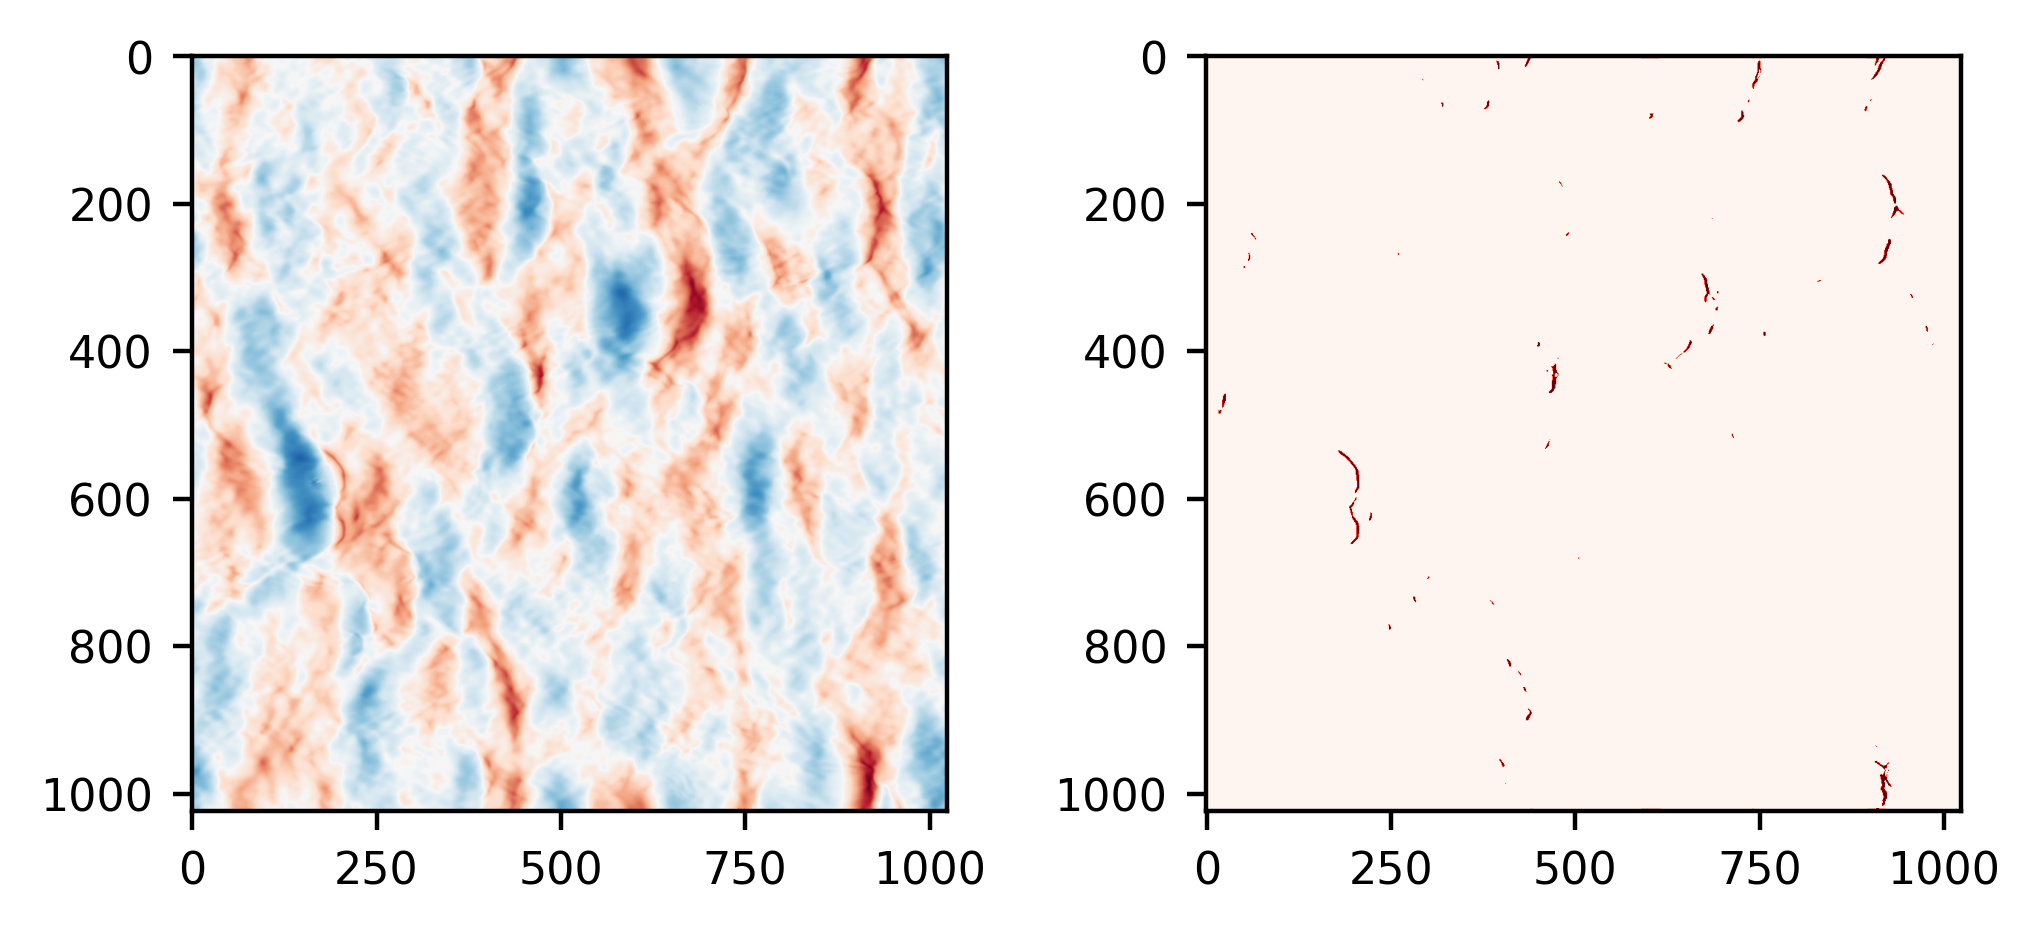

In [22]:
fig,axes = plt.subplots(1, 2, figsize=[6,2.5])
axes[0].imshow(np.rot90(case.dict1['eta']), vmax=case.dict1['eta'].max(), vmin=-case.dict1['eta'].max(), cmap='RdBu_r')
axes[1].imshow(np.rot90(area), cmap='Reds')

In [29]:
def read (t):
    global case
    N = 1024; L0=200; dx = L0/N

    filename = case.path + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]

    filename = case.path + 'surface/ux_matrix_%g' %t
    ux = np.fromfile(filename, dtype=np.float32)
    ux = ux.reshape(N+1,N+1); ux = ux[1:,1:]

    filename = case.path + 'surface/ux_matrix_%g' %t
    uy = np.fromfile(filename, dtype=np.float32)
    uy = uy.reshape(N+1,N+1); uy = uy[1:,1:]

    filename = case.path + 'surface/ux_matrix_%g' %t
    uz = np.fromfile(filename, dtype=np.float32)
    uz = uz.reshape(N+1,N+1); uz = uz[1:,1:]

    filename = case.path + 'field/omegax_matrix_t%g_l%g' %(t, case.NL-1)
    omegax_top = np.fromfile(filename, dtype=np.float32)
    omegax_top = omegax_top.reshape(N+1,N+1); omegax_top = omegax_top[1:,1:]
    
    filename = case.path + 'field/omegay_matrix_t%g_l%g' %(t, case.NL-1)
    omegay_top = np.fromfile(filename, dtype=np.float32)
    omegay_top = omegay_top.reshape(N+1,N+1); omegay_top = omegay_top[1:,1:]

    filename = case.path + 'field/omegaz_matrix_t%g_l%g' %(t, case.NL-1)
    omegaz_top = np.fromfile(filename, dtype=np.float32)
    omegaz_top = omegaz_top.reshape(N+1,N+1); omegaz_top = omegaz_top[1:,1:]

    tdict = {'t':t, 'eta':eta, 'ux':ux, 'uy':uy, 'uz':uz, 'uh':(ux**2+uy**2)**0.5, 'omegax_top':omegax_top, 'omegay_top':omegay_top, 'omegaz_top':omegaz_top}
    
    return tdict

def detect(tdict):
    global case
    cbins = np.arange(0.2,0.8,0.1)
    area = np.zeros(tdict['eta'].shape)

    for i in range(0,6):
        # level set of the horizontal velocity
        levelset = np.array((tdict['uh'] > cbins[i]*case.cp)&(tdict['uh'] < cbins[i+1]*case.cp), dtype=int)  

        # compound with the curvature criterion
        NP = 2
        eta_pad = padding(tdict['eta'], NP=NP)
        a, b = detect_ridges(eta_pad, sigma=1.0) # Maxima and minima ridges
        delta = case.L/2**case.LEVEL # Normalize the curvature by grid size
        tdict['kappa'] = b[NP:-NP,NP:-NP]/delta**2    
    
        kbin = 9.8/((cbins[i+1] + cbins[i])/2)**2
        threshold = -0.01*kbin 

        compound = levelset*np.array(tdict['kappa'] < threshold, dtype='int')
        area += compound
        
    return area

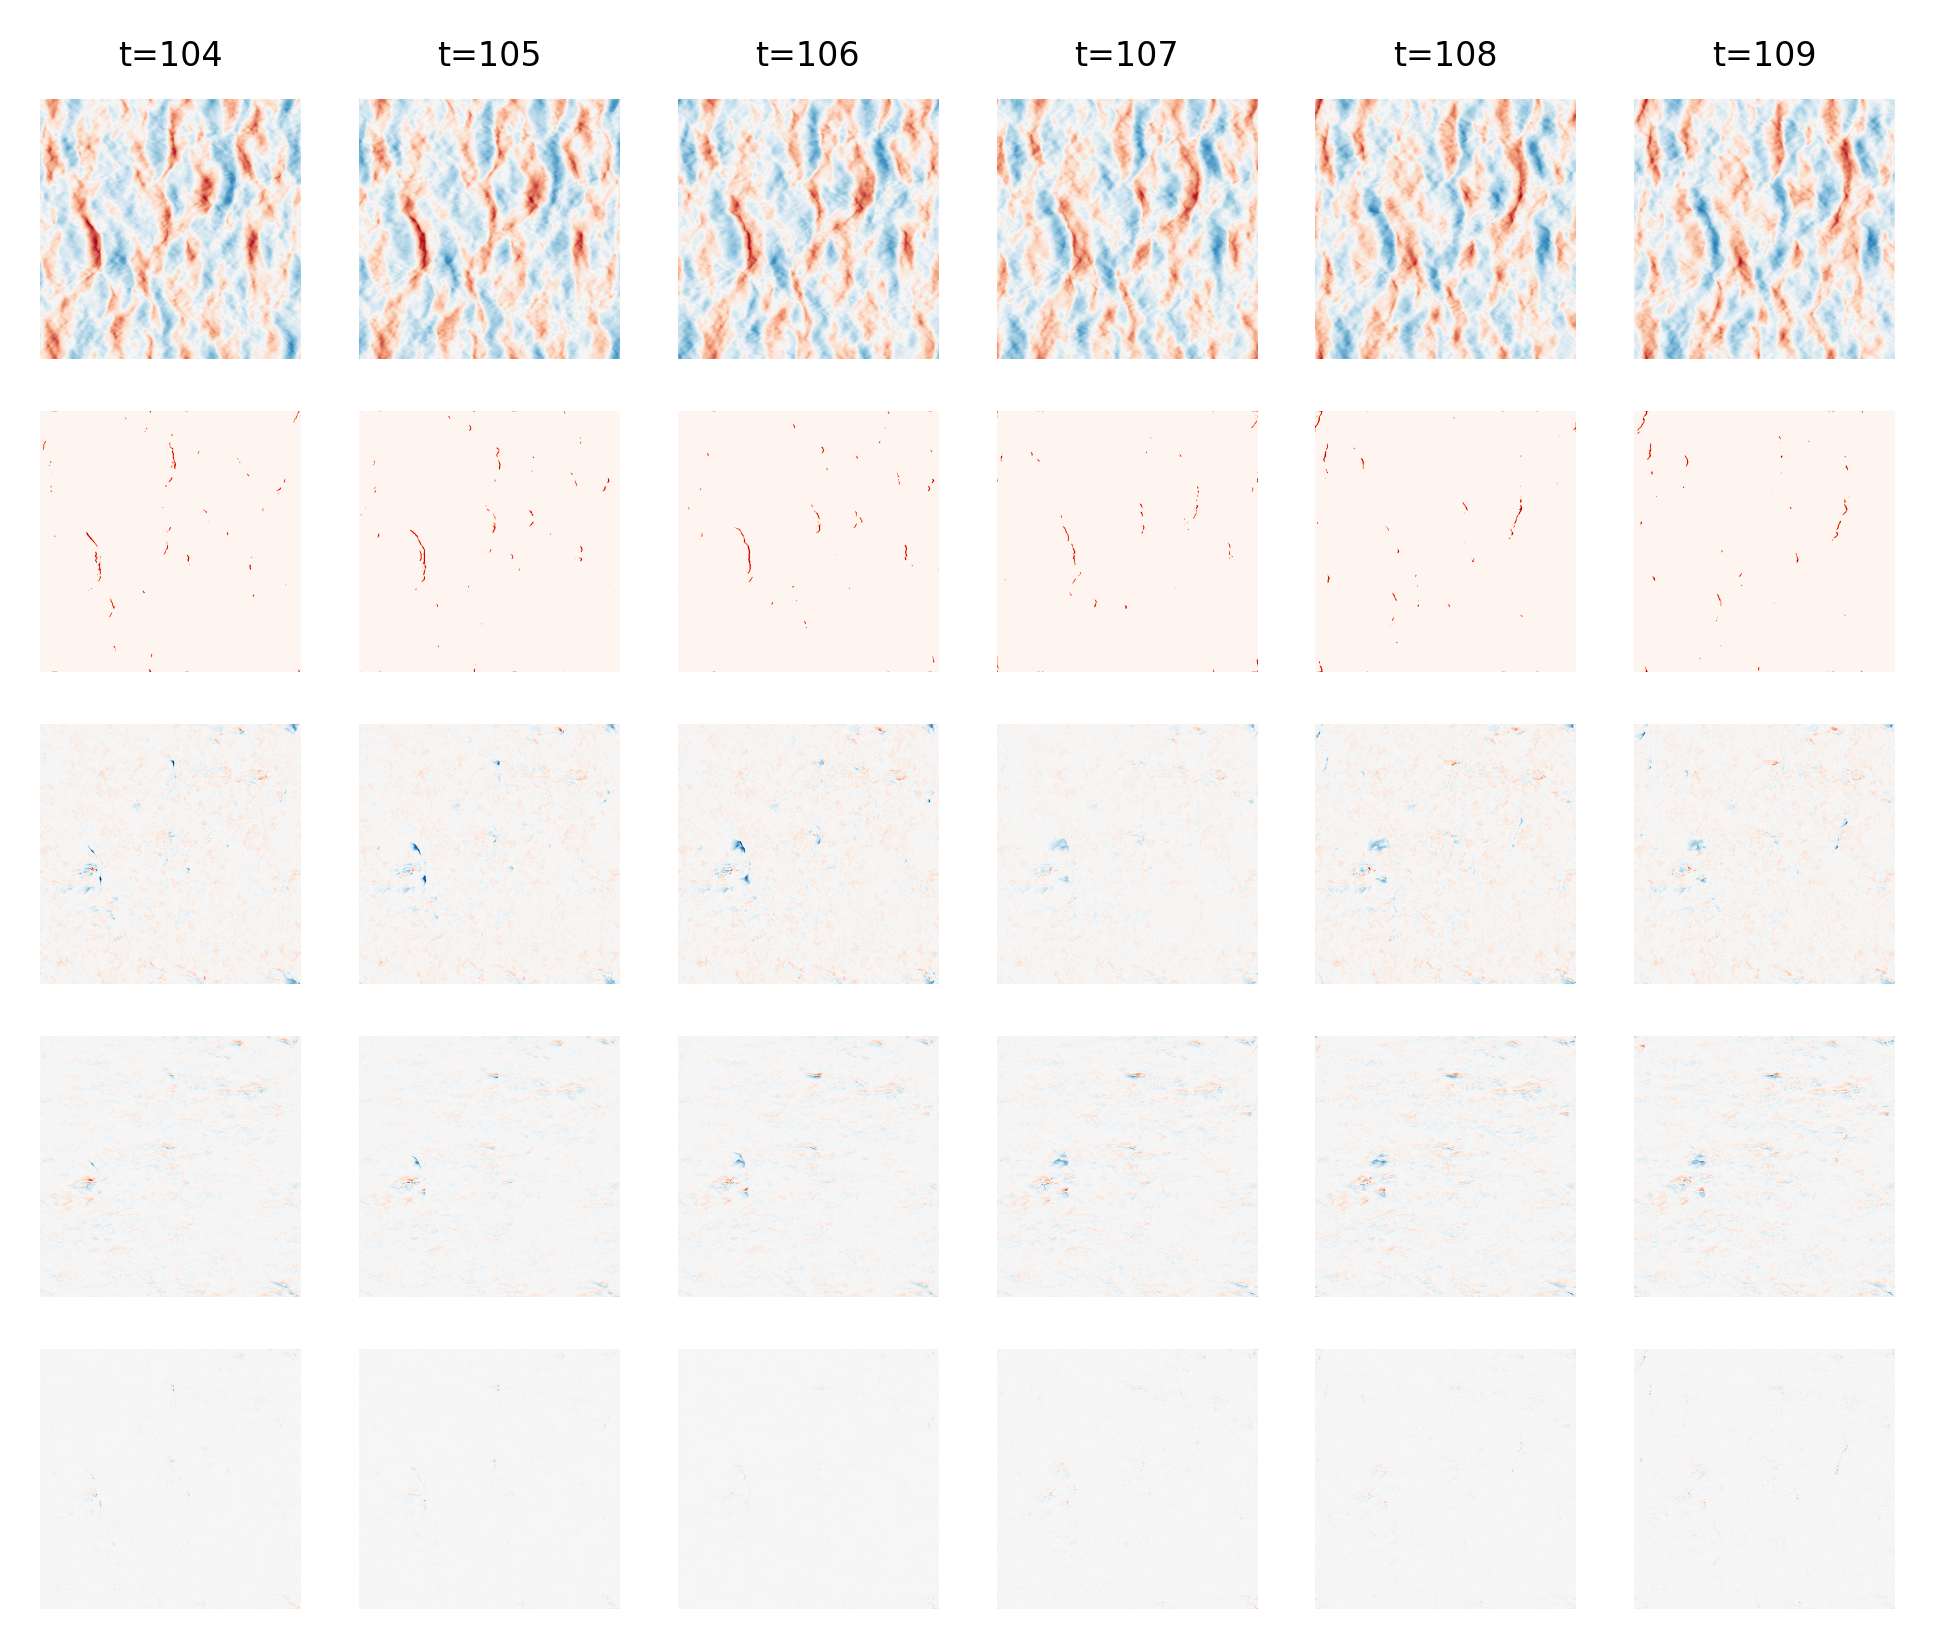

In [32]:
fig,axes = plt.subplots(5, 6, figsize=[6,5.])
for i in range(0,6):
    t = 104 + i
    axes[0,i].set_title('t=%g' %t, fontsize=6)
    
    tdict = read(t)
    axes[0,i].imshow(np.rot90(tdict['eta']), vmax=eta.max(), vmin=-eta.max(), cmap='RdBu_r')
    axes[0,i].axis('off')
    
    area = detect(tdict)
    axes[1,i].imshow(np.rot90(area), cmap='Reds')
    axes[1,i].axis('off')

    field = np.rot90(tdict['omegay_top'])
    axes[2,i].imshow(field, vmax=field.max(), vmin=-field.max(), cmap='RdBu_r')
    axes[2,i].axis('off')

    field = np.rot90(tdict['omegax_top'])
    axes[3,i].imshow(field, vmax=field.max(), vmin=-field.max(), cmap='RdBu_r')
    axes[3,i].axis('off')
    
    field = np.rot90(tdict['omegaz_top'])
    axes[4,i].imshow(field, vmax=field.max(), vmin=-field.max(), cmap='RdBu_r')
    axes[4,i].axis('off')

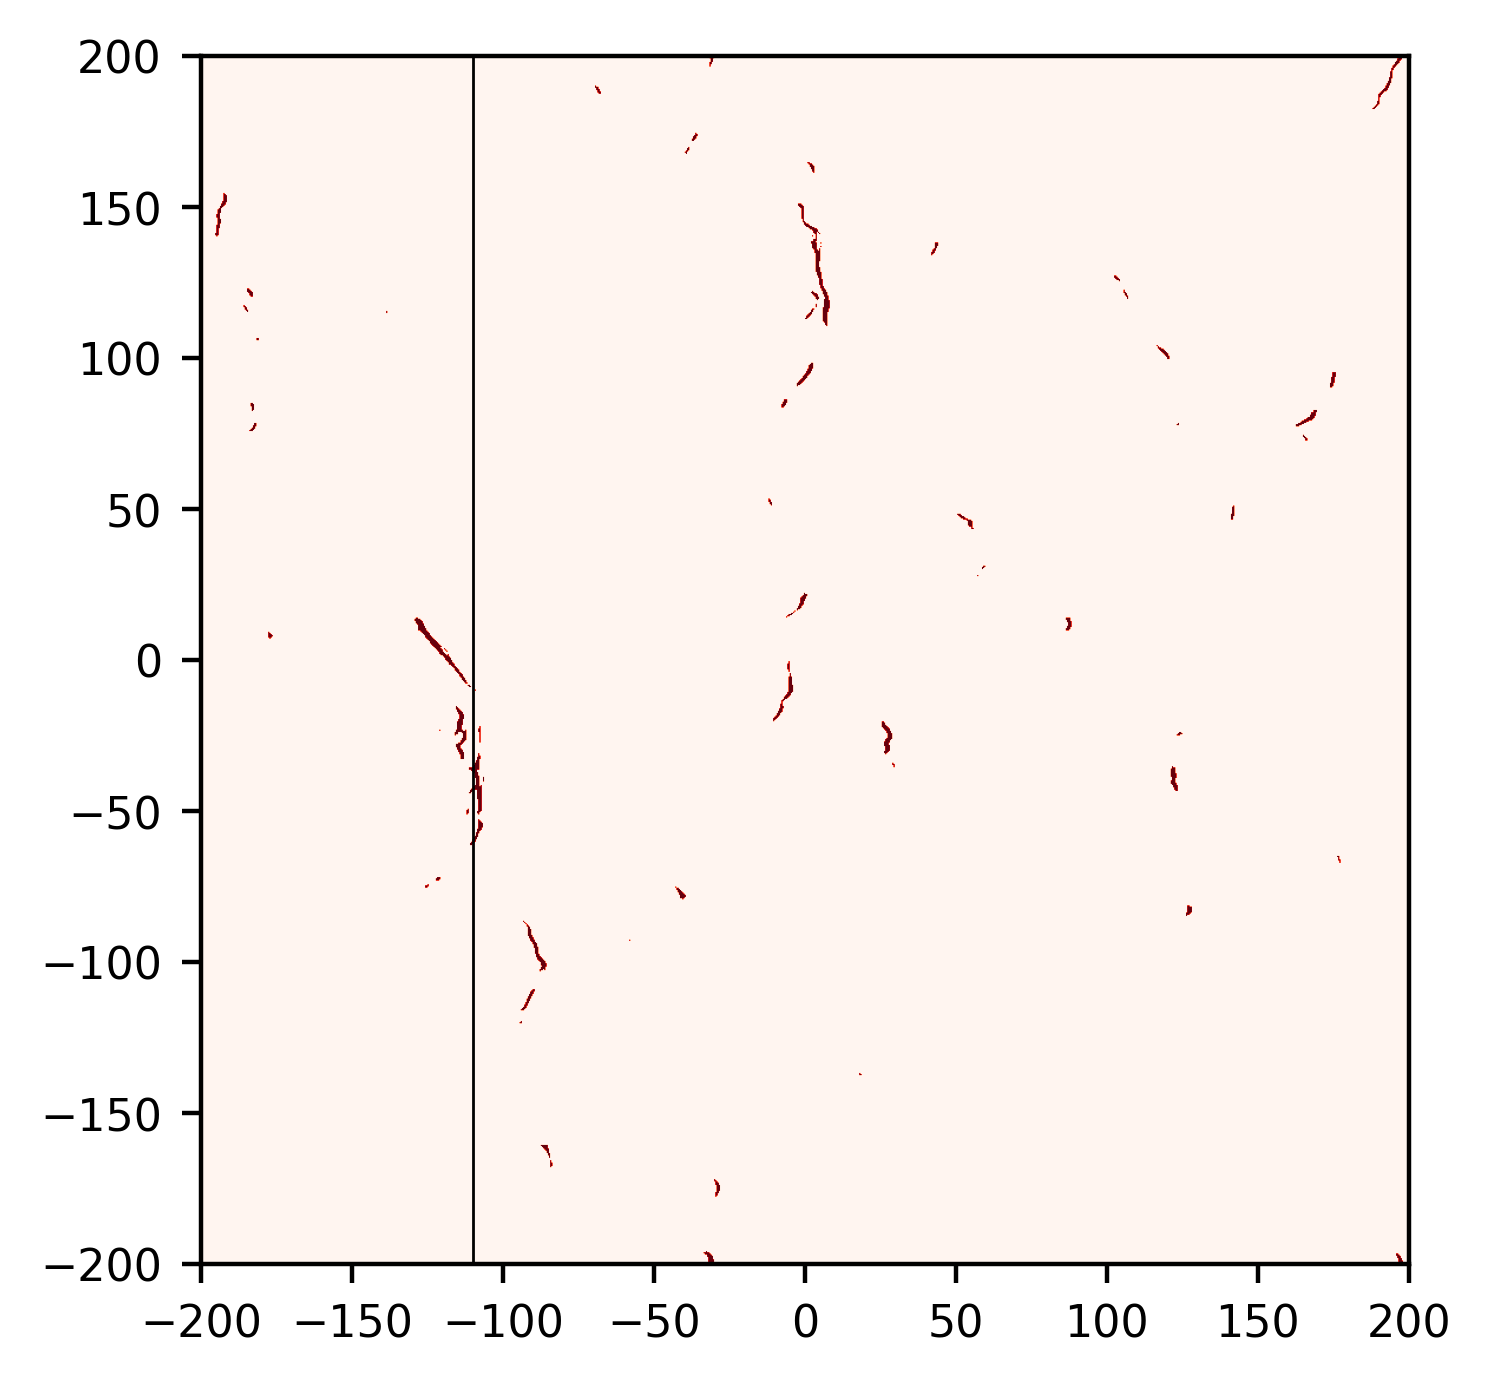

In [40]:
t = 104
tdict = read(t)
area = detect(tdict)
plt.imshow(np.rot90(area), extent=[-200,200,-200,200], cmap='Reds')
plt.axvline(-110, c='k', lw=0.5)

### Plot the level set field for curvature

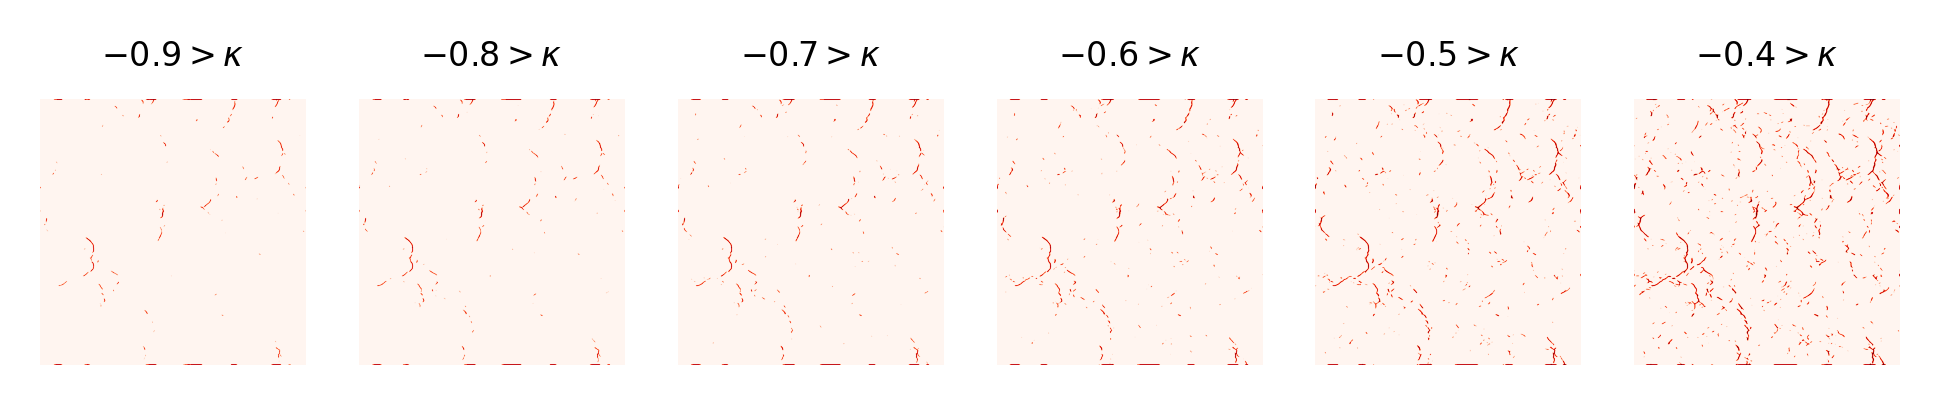

In [76]:
fig,axes = plt.subplots(1,6, figsize=[6,2.5])
kappabins = np.array((-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4))

for i in range(0,6):
    # level set of the horizontal velocity
    levelset = np.array((b_norm < kappabins[i+1]), dtype=int)
    axes[i].imshow(np.rot90(levelset), cmap='Reds')
    axes[i].axis('off')
    axes[i].set_title(r'$%g>\kappa$' %(kappabins[i+1]),fontsize=6)   

In [25]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def detect_slope(grad, threshold):
    return (np.logical_not(grad > threshold))

# if method == 0:
#     a, b = detect_ridges(eta, sigma=1.0) # Maxima and minima ridges
#     delta = self.config.L0/2**self.LEVEL # Normalize the curvature by grid size
#     b_norm = b/delta**2                
#     b_ = np.logical_not(b_norm > threshold) # Is this value fixed???
#     # Extra filtering by above 2.5 sigma (we can kind of use something between 2.5-3\sigma)
#     if EXTRA_FILTER == True:
#         height_filter = np.logical_not(eta < 2.5*np.var(eta)**0.5)
#         b_ = b_*height_filter
# elif method == 1:
#     b_ = detect_slope(eta_gradx, threshold=threshold)         


### Crest detection based on the level set field

### Crest length distribution

In [164]:
import sys
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/project_specific/turbulence')
from prepare import load_object, save_object 
import os
z_mesh_t = [] # z locations at different times
ux_t = [] # ux at different times
uy_t = [] # uy at different times
uz_t = [] # uz at different times
omegax_t = []
omegay_t = []
omegaz_t = []
dzdx_t = []
dzdy_t = []
dzdxc_t = []
dzdyc_t = []
t = 101
name = case.path + 'list_t%g.pkl' %t
if os.path.exists(name):
    [h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc, x_mesh, y_mesh, z_mesh] = load_object(name)
    print('Restored!')
else:
    print('Read in from scratch!')
    [h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc] = read_t(fieldnames=['h','ux','uy','uz','omegax','omegay','omegaz','dzdx','dzdy','dzdxc','dzdyc'], 
                                                                           t=t, Nh=Nh, Nl=Nl, path=case.path)
    x_mesh, y_mesh, z_mesh = array_to_mesh (h, L0=L, H=H, Nh=Nh, Nl=Nl)
    save_object([h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc, x_mesh, y_mesh, z_mesh], name)

Restored!


### Map the crest to underwater vorticity

In [166]:
from tqdm import tqdm
from bulk_func import array_to_mesh, read_t
import os
from prepare import load_object, save_object 

def read_full (case, tseries=(0,40,80,120,160)):
    # x and y locations should be fixed
    z_mesh_t = [] # z locations at different times
    ux_t = [] # ux at different times
    uy_t = [] # uy at different times
    uz_t = [] # uz at different times
    omegax_t = []
    omegay_t = []
    omegaz_t = []
#     dzdx_t = []
#     dzdy_t = []
#     dzdxc_t = []
#     dzdyc_t = []
    for t in tqdm(tseries):
        # If the list has been pickled
        name = case.path + 'list_t%g.pkl' %t
        if os.path.exists(name):
            [h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc, x_mesh, y_mesh, z_mesh] = load_object(name)
            print('Restored!')
        # If not pickled
        else:
            print('Read in from scratch!')
            [h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc] = read_t(fieldnames=['h','ux','uy','uz','omegax','omegay','omegaz','dzdx','dzdy','dzdxc','dzdyc'], 
                                                                                   t=t, Nh=Nh, Nl=Nl, path=case.path)
            x_mesh, y_mesh, z_mesh = array_to_mesh (h, L0=L, H=H, Nh=Nh, Nl=Nl)
            save_object([h, ux, uy, uz, omegax, omegay, omegaz, dzdx, dzdy, dzdxc, dzdyc, x_mesh, y_mesh, z_mesh], name)
    
        z_mesh_t.append(z_mesh)
        ux_t.append(ux); uy_t.append(uy); uz_t.append(uz)
        omegax_t.append(omegax); omegay_t.append(omegay); omegaz_t.append(omegaz)
#         dzdx_t.append(dzdx); dzdy_t.append(dzdy)
#         dzdxc_t.append(dzdxc); dzdyc_t.append(dzdyc)
        
#     dict_all = {'x_mesh': x_mesh, 'y_mesh': y_mesh, 'z_mesh_t': z_mesh_t, 'ux_t': ux_t, 'uy_t': uy_t, 'uz_t': uz_t, 
#                 'omegax_t': omegax_t, 'omegay_t': omegay_t, 'omegaz_t': omegaz_t, 'dzdx_t': dzdx_t, 'dzdy_t': dzdy_t, 'dzdxc_t': dzdxc_t, 'dzdyc_t': dzdyc_t}
    dict_all = {'x_mesh': x_mesh, 'y_mesh': y_mesh, 'z_mesh_t': z_mesh_t, 'ux_t': ux_t, 'uy_t': uy_t, 'uz_t': uz_t, 
                'omegax_t': omegax_t, 'omegay_t': omegay_t, 'omegaz_t': omegaz_t}

    return dict_all

In [171]:
case = case_field1
case.L = 200; case.H = 40; case.kp = 2*np.pi/case.L*5; case.cp = (9.8/case.kp)**0.5
Nh = 2**case.LEVEL; Nl = case.NL; L = case.L; H = case.H; cp = case.cp; kp = case.kp
tseries = np.arange(100,121,1)
dict1 = read_full (case, tseries=tseries)
case.fulldict = dict1

  0%|          | 0/21 [00:00<?, ?it/s]

Read in from scratch!


 10%|▉         | 2/21 [01:12<09:28, 29.92s/it]

Restored!
Read in from scratch!


 14%|█▍        | 3/21 [02:21<14:23, 47.99s/it]

Read in from scratch!


 19%|█▉        | 4/21 [03:44<17:29, 61.73s/it]

Read in from scratch!


 24%|██▍       | 5/21 [04:56<17:28, 65.52s/it]

Read in from scratch!


 29%|██▊       | 6/21 [06:07<16:51, 67.44s/it]

Read in from scratch!


 33%|███▎      | 7/21 [07:20<16:08, 69.16s/it]

Read in from scratch!


 38%|███▊      | 8/21 [08:33<15:16, 70.47s/it]

Read in from scratch!


 43%|████▎     | 9/21 [09:46<14:13, 71.13s/it]

Read in from scratch!


 48%|████▊     | 10/21 [11:00<13:12, 72.00s/it]

Read in from scratch!


 52%|█████▏    | 11/21 [12:11<11:56, 71.67s/it]

Read in from scratch!


 57%|█████▋    | 12/21 [13:22<10:43, 71.54s/it]

Read in from scratch!


 62%|██████▏   | 13/21 [14:34<09:32, 71.57s/it]

Read in from scratch!


 67%|██████▋   | 14/21 [15:46<08:21, 71.63s/it]

Read in from scratch!


 71%|███████▏  | 15/21 [16:57<07:10, 71.70s/it]

Read in from scratch!


 76%|███████▌  | 16/21 [18:07<05:55, 71.18s/it]

Read in from scratch!


 81%|████████  | 17/21 [19:20<04:46, 71.55s/it]

Read in from scratch!


 86%|████████▌ | 18/21 [20:32<03:35, 71.82s/it]

Read in from scratch!


 90%|█████████ | 19/21 [21:46<02:24, 72.28s/it]

Read in from scratch!


 95%|█████████▌| 20/21 [22:57<01:12, 72.11s/it]

Read in from scratch!


100%|██████████| 21/21 [24:07<00:00, 68.92s/it]


(-100.0, 100.0, -100.0, 100.0)

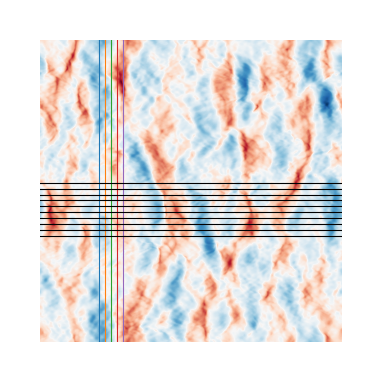

In [158]:
plt.figure(figsize=[1,1])
t = 115
tdict = read(t)
area = detect(tdict)
plt.imshow(np.rot90(tdict['eta']), vmax=tdict['eta'].max(), vmin=-tdict['eta'].max(), cmap='RdBu_r', extent=[-100,100,-100,100],)
cc = ['C0','C1','C2','C3','C4']
for i in range(0,5):
    xslice = 200 + i*20
    x = xslice/1024*200 - 100
    plt.axvline(x, c=cc[i], lw=0.2)
for i in range(0,10):
    yslice = 360 + i*20
    y = yslice/1024*200 - 100
    plt.axhline(y, c='k', lw=0.2)
plt.axis('off')

(-100.0, 100.0, -100.0, 100.0)

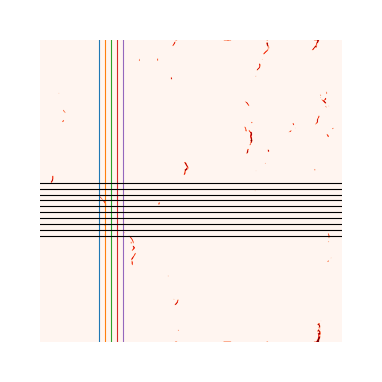

In [141]:
plt.figure(figsize=[1,1])
t = 101
tdict = read(t)
area = detect(tdict)
plt.imshow(np.rot90(area), extent=[-100,100,-100,100], cmap='Reds')
cc = ['C0','C1','C2','C3','C4']
for i in range(0,5):
    xslice = 200 + i*20
    x = xslice/1024*200 - 100
    plt.axvline(x, c=cc[i], lw=0.2)
for i in range(0,10):
    yslice = 360 + i*20
    y = yslice/1024*200 - 100
    plt.axhline(y, c='k', lw=0.2)
plt.axis('off')

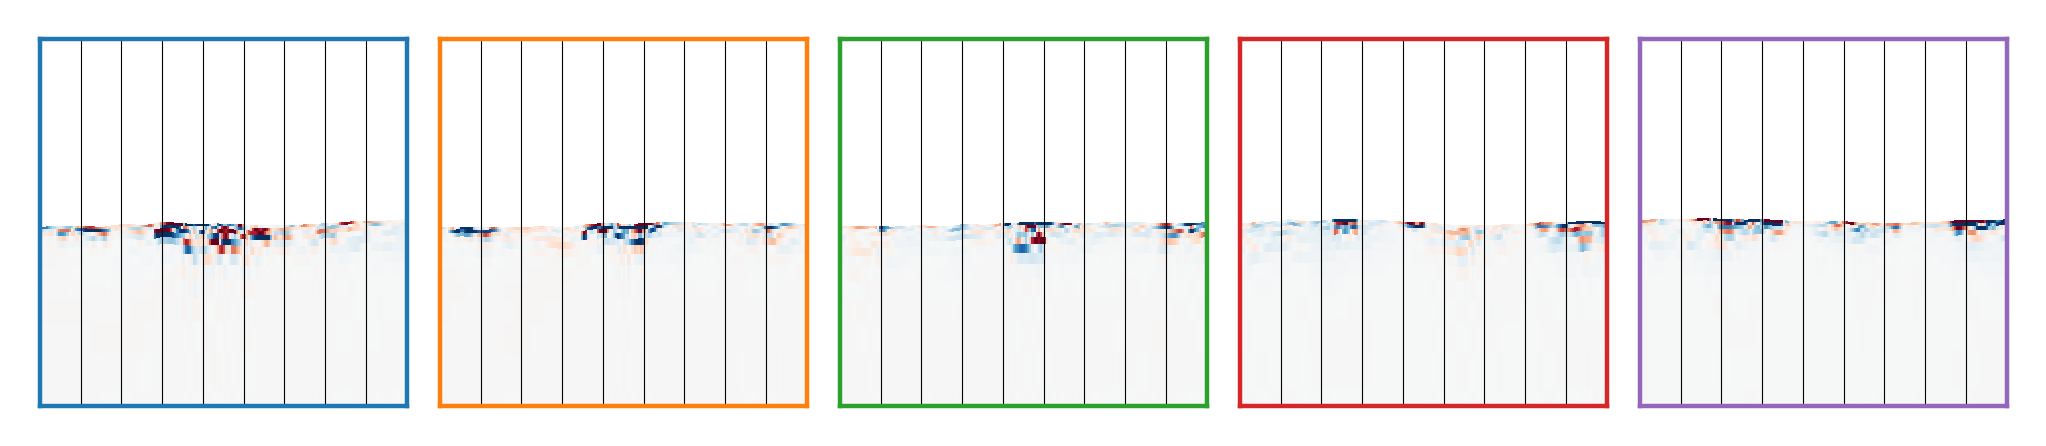

In [143]:
# fig = plt.figure (figsize=[4,2]); ax = plt.gca()
fig, axes = plt.subplots (1,5,figsize=[5,1],layout="constrained")
i = 3

ymin = 360/1024*200 - 100
ymax = (360+9*20)/1024*200 - 100
for j in range(0,5):
    xslice = 190 + j*20
    Nh = 2**case.LEVEL; Nl = case.NL; L = case.L; H = case.H; cp = case.cp; kp = case.kp    
    field = case.fulldict['omegay_t'][i][:,xslice,:]
    image = axes[j].pcolormesh(case.fulldict['y_mesh'][:,xslice,:], case.fulldict['z_mesh_t'][i][:,xslice,:], field,
                      shading='flat', cmap='RdBu_r', vmax=0.6, vmin=-0.6)
#     axes[j].set_xticks([-L/2,L/2]); axes[j].set_yticks([-L/5,0,L/10])
    axes[j].set_ylim([-L/10,L/10]); axes[j].set_xlim([ymin,ymax])
#     axes[j].axis('off')
    axes[j].tick_params(left = False, right = False , labelleft = False ,
                            labelbottom = False, bottom = False)
    for spine in axes[j].spines.values():
        spine.set_edgecolor(cc[j])
    
    for k in range(0,10):
        yslice = 360 + k*20
        y = yslice/1024*200 - 100
        axes[j].axvline(y, c='k', lw=0.2)
        
# print(dzdx_t[i].max(), dzdx_t[i].min())
# print(dzdy_t[i].max(), dzdy_t[i].min())
# plt.colorbar(image)
# ax.axvline(-60, c='k', lw=0.5); ax.axvline(-10, c='k', lw=0.5)
# 0.17117248 -0.2046054
# 0.17087948 -0.13110258

### Old function of crest detection and particle tracking

In [14]:
images = [color.rgb2gray(color.rgba2rgb(io.imread('frame{}.png'.format(i)))) for i in [1, 2]]

ppties = ['label', 'area', 'centroid', 'eccentricity', 'orientation', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length']

def detect_crests(im):
    im_lab = measure.label(im) #im: binary image
    props = measure.regionprops_table(im_lab, properties=ppties)
    #link: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    return pd.DataFrame(props).set_index('label')

crests = [detect_crests(im) for im in images]

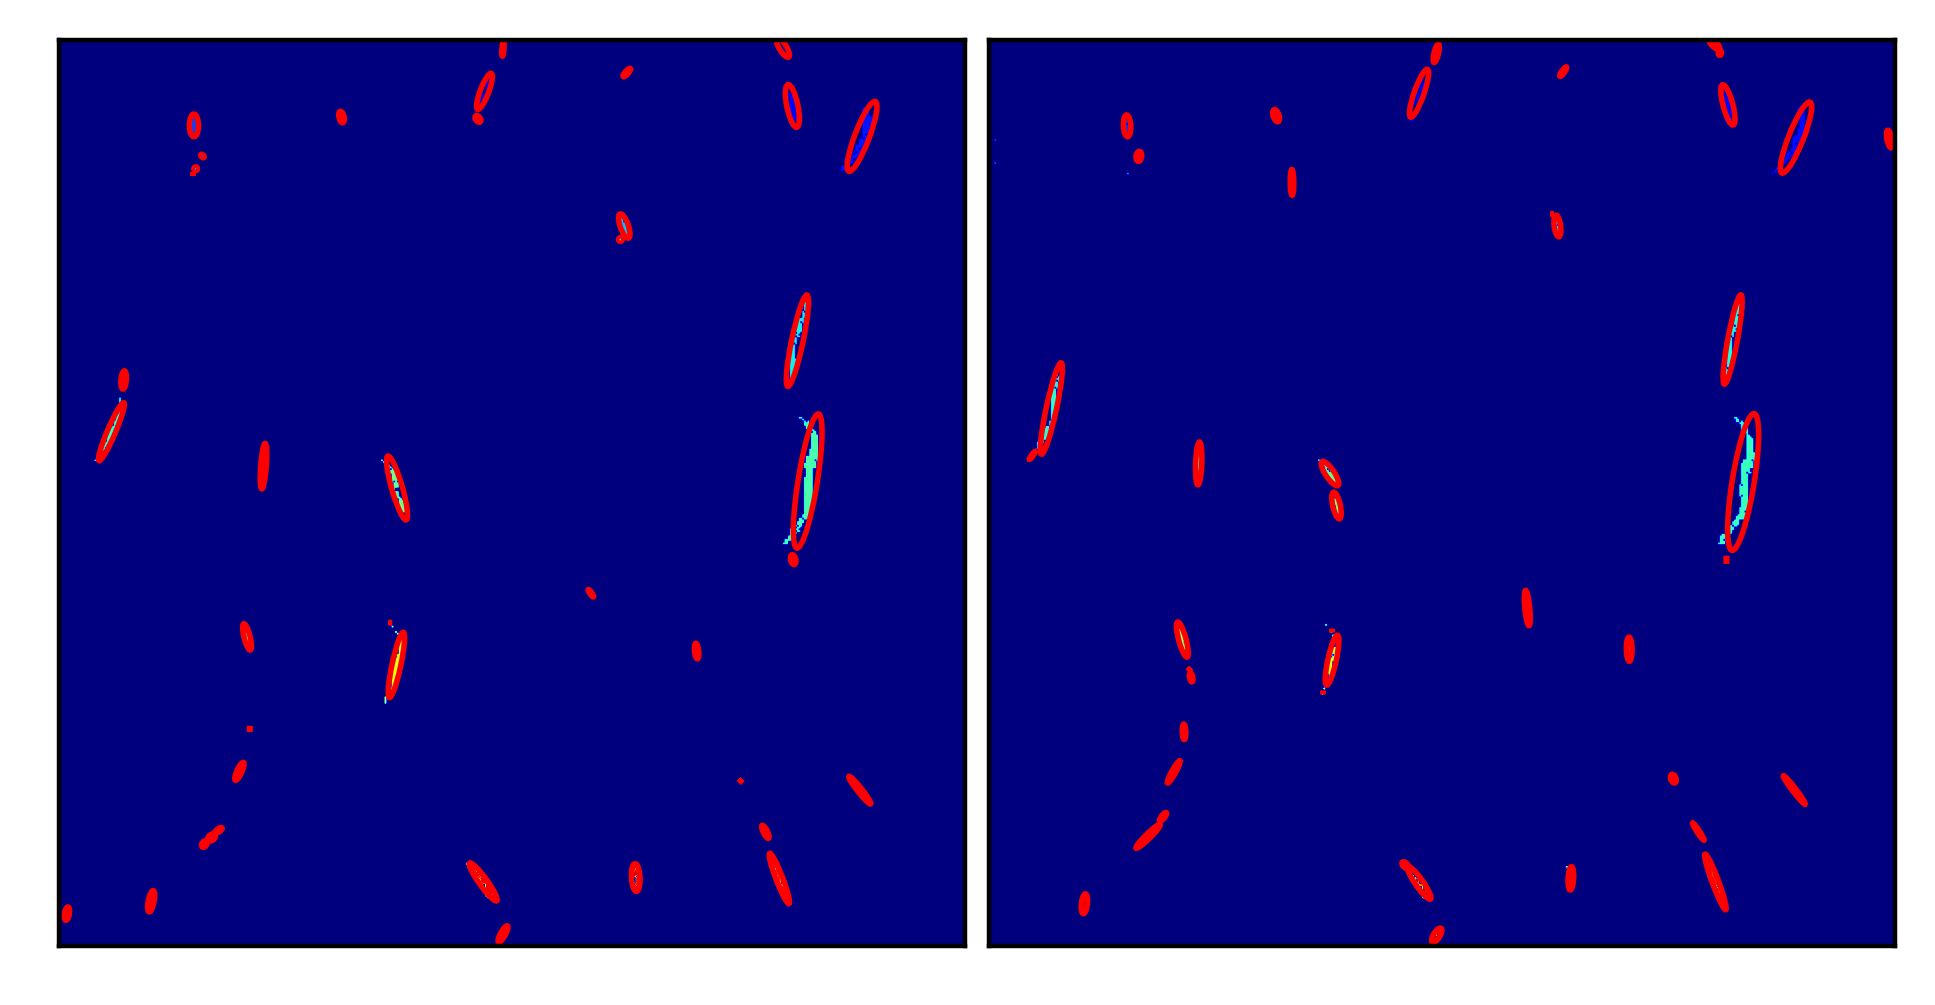

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

angle = lambda theta: np.degrees((2*(theta>=0)-1)*np.pi/2 - theta)

cm = plt.get_cmap('jet')
for im, ax, props in zip(images, axs, crests):
    ax.imshow(measure.label(im), cmap=cm)
    ax.set_xticks(())
    ax.set_yticks(())
    for i, p in props.iterrows():
        e = Ellipse(p[['centroid-1', 'centroid-0']], p['major_axis_length'], p['minor_axis_length'],
                   angle(p['orientation']), ec='r', fc='none')
        ax.add_patch(e)
        

## Track crests

Histogram of distances between detected crests: ideally the minimal distance between 2 crests (in a single frame) should be larger than the maximal displacement between 2 frames.

In [ ]:
dist = np.concatenate([distance.pdist(c[['centroid-0', 'centroid-1']]) for c in crests])
fig, ax = plt.subplots()
out = ax.hist(dist, bins=np.logspace(0, 3, 20), density=True)
ax.set_yscale('log')
ax.set_xscale('log')

Aaaaaand... the min. distance is 2.5 here, so let's try `search_range=2`. Which does not seem to work. I would stick with something between 5 and 10, since most of the distances are higher than that.

In [16]:
crests_df = pd.concat(dict(enumerate(crests)), names=['frame']).reset_index()
crests_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'}, inplace=True)
crests_df = tp.link_df(crests_df, search_range=5)

crests_gr = crests_df.groupby('particle')
crests_df['dx'] = crests_gr['x'].diff()
crests_df['dy'] = crests_gr['y'].diff()

Frame 1: 50 trajectories present.


In [27]:
crests_df[np.isnan(crests_df.dx)==False]

frame  label  area           y           x  eccentricity  orientation  \
72      1     32    35  344.000000  361.028571      0.971137     0.015825   
68      1     28    49  338.571429  108.510204      0.979049     0.262543   
69      1     29     1  330.000000  190.000000      0.000000     0.785398   
71      1     31    72  350.208333  193.111111      0.986497    -0.214483   
77      1     37    15  390.733333  109.466667      0.973723     0.027749   
87      1     47    32  476.125000  242.406250      0.980152     0.609988   
79      1     39    12  417.166667  386.000000      0.810370     0.345668   
80      1     40    22  423.590909  454.318182      0.995016     0.652685   
82      1     42    32  449.750000   89.187500      0.989716    -0.793024   
83      1     43    11  447.090909  400.090909      0.992961     0.582560   
84      1     44    79  475.544304  409.759494      0.994109     0.356220   
88      1     48    25  473.520000  328.080000      0.971604    -0.055398   
66      1     26     4  293.500000  416.000000      1.000000     0.000000   
78      1     38    20  413.350000  103.650000      0.988040    -0.505992   
45      1      5    63   29.857143  242.269841      0.981194    -0.338191   
41      1      1    13    2.153846  409.153846      0.928218     0.808432   
42      1      2    19    7.263158  252.000000      0.971737    -0.232389   
44      1      4     8   17.625000  323.750000      0.965013    -0.610726   
89      1     49    27  487.888889   53.148148      0.953450    -0.108056   
46      1      6    65   36.415385  416.830769      0.971981     0.256846   
47      1      7   133   54.894737  455.315789      0.981078    -0.378461   
48      1      8    18   42.500000  161.500000      0.888523     0.321751   
49      1      9    38   48.263158   77.289474      0.941035     0.050862   
56      1     16     1   75.000000   78.000000      0.000000     0.785398   
58      1     18    33  104.848485  320.484848      0.954556     0.130842   
59      1     19   145  169.041379  419.489655      0.994351    -0.183354   
61      1     21   301  249.544850  425.425249      0.987274    -0.160550   
62      1     22    61  239.032787  117.754098      0.989516    -0.036530   
52      1     12    14   65.500000   83.928571      0.831302    -0.131497   
90      1     50    20  505.700000  252.250000      0.918818    -0.553821   

    equivalent_diameter  major_axis_length  minor_axis_length  particle  \
72             6.675581          13.557833           3.233855         4   
68             7.898654          20.483668           4.171003         1   
69             1.128379           0.000000           0.000000         2   
71             9.574615          28.823998           4.720718         3   
77             4.370194           8.701580           1.981655         5   
87             6.383076          22.143582           4.389890        13   
79             3.908820           5.047399           2.957361         8   
80             5.292567          20.118872           2.006087         7   
82             6.383076          19.078508           2.729106         9   
83             3.742410          11.600639           1.374043        20   
84            10.029253          33.439653           3.624436        12   
88             5.641896          13.121429           3.104723        14   
66             2.256758           4.472136           0.000000        22   
78             5.046265          14.283869           2.202516         6   
45             8.956232          28.571773           5.515086        25   
41             4.068429           7.876559           2.930364         0   
42             4.918491          10.555550           2.491820        23   
44             3.191538           6.324555           1.658312        24   
89             5.863230          11.179254           3.371125        15   
46             9.097284          23.427652           5.506922        26   
47            13.013103          43.10680

(512.0, 0.0)

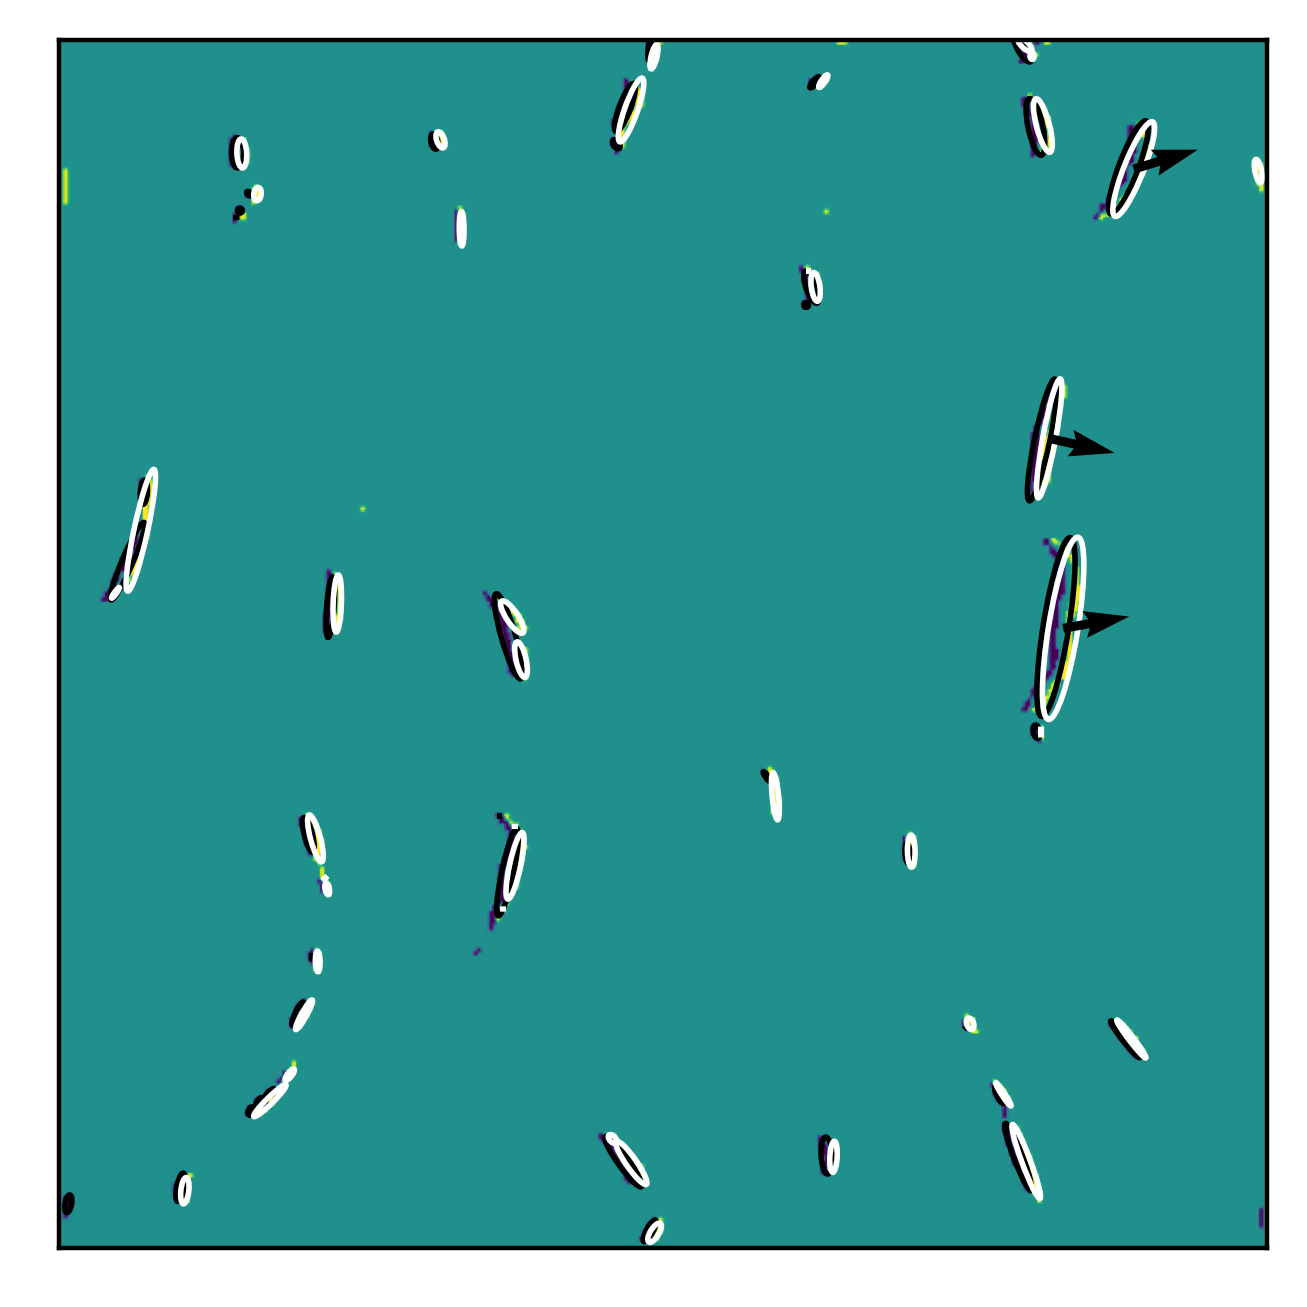

In [53]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.diff(images, axis=0)[0])
for c, props in zip('kw', crests):
    for i, p in props.iterrows():
        e = Ellipse(p[['centroid-1', 'centroid-0']], p['major_axis_length'], p['minor_axis_length'],
                   angle(p['orientation']), ec=c, fc='none')
        ax.add_patch(e)
# ax.quiver(*crests_df[['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==21][['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==7][['x', 'y', 'dx', 'dy']].values.T, )
ax.quiver(*crests_df[crests_df.label==19][['x', 'y', 'dx', 'dy']].values.T, )
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlim(0, 512)
ax.set_ylim(512, 0)

In [56]:
print (crests_df[crests_df.label==21].dx*50/512/0.1)
print (crests_df[crests_df.label==7].dx*50/512/0.1)
print (crests_df[crests_df.label==19].dx*50/512/0.1)

20         NaN
61    2.996422
Name: dx, dtype: float64
6          NaN
47    2.189418
Name: dx, dtype: float64
18         NaN
59    2.890863
Name: dx, dtype: float64


## Refine analysis
Then you can refine the analysis based on the shape of the crests (ideas):
- take orientation and/or eccentricity into account,
- once you match the crests from one frame to the next, you could interpolate each crest on a line $\{x(s), y(s)\}$, with the arclength $s$ from 0 to 1, then at fixed $s$ calculate the displacement between 2 frames (treat it as a material point).

### Work on a single wave crest
Get largest wave crest on both frames, then skeletonize, retrieve coordinates and fit a smooth spline on it.

In [30]:
def detect_crests(im):
    im_lab = measure.label(im) #im: binary image
    props = measure.regionprops(im_lab) #output region properties in their native format
    #link: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    return props

# get largest crest
props = [detect_crests(im) for im in images]
crest = [x[np.argmax([p.area for p in x])] for x in props]

In [40]:
dir(crest[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_extra_properties',
 '_image_intensity_double',
 '_intensity_image',
 '_label_image',
 '_multichannel',
 '_ndim',
 '_slice',
 '_spatial_axes',
 'area',
 'area_bbox',
 'area_convex',
 'area_filled',
 'axis_major_length',
 'axis_minor_length',
 'bbox',
 'centroid',
 'centroid_local',
 'centroid_weighted',
 'centroid_weighted_local',
 'coords',
 'eccentricity',
 'equivalent_diameter_area',
 'euler_number',
 'extent',
 'feret_diameter_max',
 'image',
 'image_convex',
 'image_filled',
 'image_intensity',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'i

213 409 285 429
213 412 285 433


(290.0, 210.0)

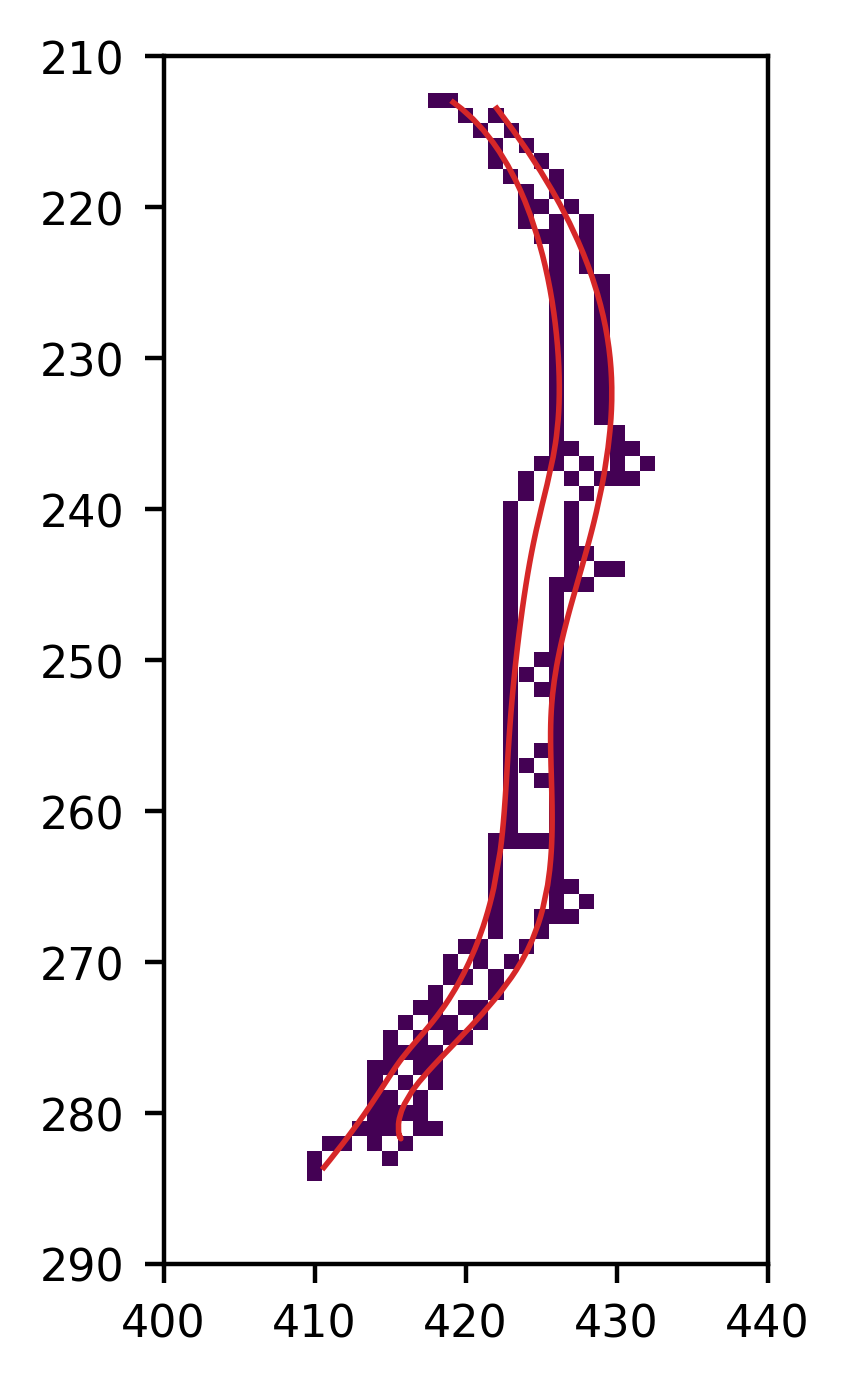

In [41]:
fig, ax = plt.subplots()
splines = []
for c in crest:
    r0, c0, r1, c1 = c.bbox
    print(r0,c0,r1,c1)
    skel = morphology.skeletonize(c.image)
    ax.imshow(~np.ma.masked_equal(skel, 0), extent=np.r_[c0, c1, r1, r0]-.5)
    r, c = np.where(skel > 0)
    s = np.cumsum(np.sqrt(np.diff(r)**2+np.diff(c)**2))
    s = np.concatenate([[0], s])/s[-1]
    x = itp.splrep(s, c+c0, k=3, s=100)
    y = itp.splrep(s, r+r0, k=3, s=100)
    splines.append([x, y])
    ax.plot(itp.splev(s, x), itp.splev(s, y), 'C3', lw=1)

ax.set_xlim(400, 440)
ax.set_ylim(290, 210)